In [1]:
import pandas as pd
import numpy as np
import re
import pickle
import string

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import jaccard_score


import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


# Loading in data about Bay Area elections

In [4]:
#loading in an excel document containing all of the polticians running for office on March 3rd, 2020
#This was found here: https://www.sos.ca.gov/elections/prior-elections/statewide-election-results/presidential-primary-election-march-3-2020/statement-vote/
df = pd.read_excel('data/csv-voter-nominated-candidates.xls')

In [5]:
sf_df = df[df['COUNTY_NAME'] == 'San Francisco']

In [6]:
#to test I'm only looking at politicians in my district in SF
mask_13th = sf_df.CONTEST_NAME != 'United States Representative District 13'
mask_14th = sf_df.CONTEST_NAME != 'United States Representative District 14'
mask_19th = sf_df.CONTEST_NAME != 'State Assembly Member District 19'

sf_df[mask_13th & mask_14th & mask_19th]

,ELECTION_DATE,ELECTION_NAME,COUNTY_ID,COUNTY_NAME,CONTEST_ID,CONTEST_NAME,CANDIDATE_ID,CANDIDATE_NAME,INCUMBENT_FLAG,WRITE_IN_FLAG,PARTY_ID,PARTY_NAME,VOTE_TOTAL
831,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,110000120000,United States Representative District 12,571,Nancy Pelosi,Y,N,1,Democratic,190590
832,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,110000120000,United States Representative District 12,866,Agatha Bacelar,N,N,1,Democratic,3890
833,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,110000120000,United States Representative District 12,867,Shahid Buttar,N,N,1,Democratic,33344
834,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,110000120000,United States Representative District 12,869,John Dennis,N,N,3,Republican,19883
835,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,110000120000,United States Representative District 12,873,Tom Gallagher,N,N,1,Democratic,5094
836,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,110000120000,United States Representative District 12,879,Deanna Lorraine,N,N,3,Republican,4635
843,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,120000110000,State Senate District 11,533,Scott Wiener,Y,N,1,Democratic,154001
844,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,120000110000,State Senate District 11,831,Jackie Fielder,N,N,1,Democratic,92141
845,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,120000110000,State Senate District 11,832,Erin Smith,N,N,3,Republican,29285
846,03/03/2020,2020 Statewide Direct Primary,38,San Francisco,130000170000,State Assembly Member District 17,617,David Chiu,Y,N,1,Democratic,120498


Ok the plan is to scrape the twitter feeds for all of these people and then perform NLP on the resulting data. First let's test the NLP pipeline with Nancy Pelosi's tweets

In [8]:
pelosi_tweets = pd.read_csv('data/SpeakerPelosi_03_2019_to_03_2020.csv')

# Preprocessing pipeline

In [9]:
#lemmatization function taken from Selva Prabhakaran's post on Machine Learning Plus
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [10]:
def text_clean(data):
    """
    Purpose: Takes tweets in a dataframe, cleans each tweet and returns an array with cleaned tweets.
    Arguments: dataframe of tweets for a column called "text" containing the text of the tweet
    Returns: cleaned array of tweets
    """
    
    df = data.text.drop_duplicates()
    
    #taking our URLs
    urls = lambda x: re.sub(r'http\S+', '' ,str(x))

    #taking out capitalization and digits
    alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', str(x))

    #removing punctuation
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', str(x).lower())
    
    #applies the above three functions on the data
    df = df.map(urls).map(alphanumeric).map(punc_lower)
    
    #turn data into a list of tweets
    data_list = [x for x in df]
    
    #initialize lemmatizer
    lemmatizer = WordNetLemmatizer()

    #lemmatize the words
    data = []
    for sentence in data_list:
        data.append([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence)])
    
    #combine the words back into tweets
    final = []
    for sentence in data:
        final.append(' '.join(sentence))
    
    return final
    

In [11]:
#function taken from Metis lecture slides to help display the topics and the top words per topic
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [12]:
result = text_clean(pelosi_tweets)
result

['every time an american be force to ration medication or not fill a prescription it s a failure of senate republican the house have vote to allow hhs to negotiate for lowerdrugcosts how long do family have to wait for senatemajldr to do the same',
 'the aca be a pillar of health economic security for american family — and even more critical during an epidemic but in the middle of the coronavirus crisis the trump admin continue to ask the court to tear health coverage away from million',
 'cautiously optimistic about u s taliban agreement for condition base troop drawdown many significant additional step remain to achieve comprehensive and endure peace afghan woman must be at the negotiate table their voice must be heard',
 'womenshistorymonth reminds u that when woman succeed america succeed',
 'congress be take step to ensure the government have access to the resource need to combat this deadly virus keep american safe house appropriator be work hard on a funding package which we hop

In [13]:
#adding custom stop words for this use case
addl_stop_words = ['live', 'today', 'must', 'join', 'campaign', 'reporter', 'tune', 'pm', 'et', 'press','weekly',
                  'year','thank', 'thanks', 'support', 'appreciate', 'rsvp', 'say', 'get', 'amp']

custom_stop_words = stopwords.words('english') + addl_stop_words

# Testing out data manipulation

## Assembling the vectors with words as features

In [14]:
def create_sentiment_vectors(list_of_tweets,handle,word=None):
    """
    Purpose: Get total positive, neutral, negative and compound sentiment scores for each tweet and then return the sum
    of all those scores in a single vector for each politician
    Arguments: List of tweets
    Returns: One row dataframe with total sentiment scores for that politician
    """
    
    #Initializing variables
    neg = 0
    neu = 0
    pos = 0 
    compound = 0
    
    #initializing sentiment analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    #performing sentiment analysis on a tweet by tweet basis
    for val in list_of_tweets:
        sentiment_dict = analyzer.polarity_scores(val)
        neg += sentiment_dict['neg']
        neu += sentiment_dict['neu']
        pos += sentiment_dict['pos']
        compound += sentiment_dict['compound']
    
    #conditional logic that will change behavior based on if this sentiment vector is only for one word or the whole df
    if word is not None:
        final = pd.DataFrame([[neg,neu,pos,compound]], index=[handle],
                             columns= [word + '_' + val for val in sentiment_dict.keys()])
    else:
        final = pd.DataFrame([[neg,neu,pos,compound]], index=[handle], columns= sentiment_dict.keys())
        
    return final

In [43]:
def get_politician_vectors(twitter_handle,top_words=True,top_words_amount=200):
    """
    Purpose: Take politician tweets from last year and turn it vector of words 
    Arguments: Twitter handle in string
    Returns: Dataframe with vector and number of tweets
    """

    #adding custom stop words for this use case
    addl_stop_words = ['live', 'today', 'must', 'join', 'campaign', 'reporter', 'tune', 'pm', 'et', 'press','weekly',
                  'year','thank', 'thanks', 'support', 'appreciate', 'rsvp', 'say', 'get', 'amp']

    custom_stop_words = stopwords.words('english') + addl_stop_words
    
    #load in data
    file = 'data/' + twitter_handle + '_03_2019_to_03_2020.csv'
    df = pd.read_csv(file)
    
    #clean the data
    result = text_clean(df)
    number_of_tweets = len(result)
    
    #create the document-term matrix
    tfidf = TfidfVectorizer(stop_words=custom_stop_words,ngram_range=(1,3), min_df = 5, max_df=.9, binary=True)
    doc_word = tfidf.fit_transform(result)
    doc_word_df = pd.DataFrame(doc_word.toarray(),index=df.text.drop_duplicates(),columns=tfidf.get_feature_names())
    
    #sum up all columns to get a politican-term vector
    data = np.zeros((1,len(doc_word_df.columns)))
    for i,column in enumerate(doc_word_df.columns):
        data[0,i] = doc_word_df[column].sum()
    
    #put the sums into a new dataframe
    final = pd.DataFrame(data,index=[twitter_handle], columns=doc_word_df.columns)
        
    #get sentiment for top words and add them to the dataframe
    if top_words == True:
        top_words = list(final.T.sort_values(by=twitter_handle,ascending=False).index[0:top_words_amount])
        for word in top_words:
            mini_df = pd.DataFrame(result,columns=['text'])
            tweets_for_this_word = mini_df[mini_df.text.str.contains(word)].text.to_list()
            if len(tweets_for_this_word) != 0:
                senti_df = create_sentiment_vectors(tweets_for_this_word,twitter_handle,word)
                for column in senti_df.columns:
                    final[column] = senti_df.at[twitter_handle,column]

    return final,number_of_tweets

In [44]:
#using the above function in a for loop to organize all poltician vectors into one dataframe

twitter_handles = ['AgathaBacelar', 'DavidChiu', 'DeAnna4Congress', 'erinsmithSF', 'JackieFielder_',
                  'RealJohnDennis', 'Scott_Wiener', 'ShahidForChange', 'SpeakerPelosi', 'TomGallagherSF']

for i,handle in enumerate(twitter_handles):
    df,num_tweets = get_politician_vectors(handle,top_words=True,top_words_amount=200)
    if i > 0:
        big_df = pd.concat([big_df, df], axis=0)
    else:
        big_df = df
    print(str(i) + ' completed!')

big_df

0 completed!
1 completed!
2 completed!
3 completed!
4 completed!
5 completed!
6 completed!
7 completed!
8 completed!
9 completed!


,able,absolutely,access,accord,across,act,action,actually,actually increase,additional,...,via change_pos,via change_compound,petition via_neg,petition via_neu,petition via_pos,petition via_compound,petition via change_neg,petition via change_neu,petition via change_pos,petition via change_compound
AgathaBacelar,1.592918,5.899866,1.543891,1.988780,3.936818,3.398603,5.717011,3.148711,1.894575,1.743352,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DavidChiu,4.632526,NaN,3.902950,NaN,3.742977,3.083046,3.434456,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DeAnna4Congress,7.367748,6.589602,NaN,NaN,1.541946,7.325702,4.442053,20.807721,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
erinsmithSF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
JackieFielder_,NaN,NaN,NaN,NaN,NaN,3.451876,NaN,2.396331,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RealJohnDennis,NaN,2.463268,NaN,NaN,2.015004,NaN,3.312497,2.992200,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Scott_Wiener,5.285572,1.877253,10.881592,4.186577,NaN,9.415104,6.759160,4.247445,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ShahidForChange,2.254856,4.232785,4.146175,NaN,19.954791,11.461734,21.781062,3.290216,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SpeakerPelosi,2.793834,NaN,4.518422,NaN,12.151418,23.425634,12.008834,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TomGallagherSF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.236,-3.8734,1.204,3.56,0.236,-2.9984,1.204,3.56,0.236,-2.9984


# Visualizing the Vectors

In [45]:
big_df = big_df.fillna(0)

In [46]:
big_df

,able,absolutely,access,accord,across,act,action,actually,actually increase,additional,...,via change_pos,via change_compound,petition via_neg,petition via_neu,petition via_pos,petition via_compound,petition via change_neg,petition via change_neu,petition via change_pos,petition via change_compound
AgathaBacelar,1.592918,5.899866,1.543891,1.988780,3.936818,3.398603,5.717011,3.148711,1.894575,1.743352,...,0.000,0.0000,0.000,0.00,0.000,0.0000,0.000,0.00,0.000,0.0000
DavidChiu,4.632526,0.000000,3.902950,0.000000,3.742977,3.083046,3.434456,0.000000,0.000000,0.000000,...,0.000,0.0000,0.000,0.00,0.000,0.0000,0.000,0.00,0.000,0.0000
DeAnna4Congress,7.367748,6.589602,0.000000,0.000000,1.541946,7.325702,4.442053,20.807721,0.000000,0.000000,...,0.000,0.0000,0.000,0.00,0.000,0.0000,0.000,0.00,0.000,0.0000
erinsmithSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000,0.0000,0.000,0.00,0.000,0.0000,0.000,0.00,0.000,0.0000
JackieFielder_,0.000000,0.000000,0.000000,0.000000,0.000000,3.451876,0.000000,2.396331,0.000000,0.000000,...,0.000,0.0000,0.000,0.00,0.000,0.0000,0.000,0.00,0.000,0.0000
RealJohnDennis,0.000000,2.463268,0.000000,0.000000,2.015004,0.000000,3.312497,2.992200,0.000000,0.000000,...,0.000,0.0000,0.000,0.00,0.000,0.0000,0.000,0.00,0.000,0.0000
Scott_Wiener,5.285572,1.877253,10.881592,4.186577,0.000000,9.415104,6.759160,4.247445,0.000000,0.000000,...,0.000,0.0000,0.000,0.00,0.000,0.0000,0.000,0.00,0.000,0.0000
ShahidForChange,2.254856,4.232785,4.146175,0.000000,19.954791,11.461734,21.781062,3.290216,0.000000,0.000000,...,0.000,0.0000,0.000,0.00,0.000,0.0000,0.000,0.00,0.000,0.0000
SpeakerPelosi,2.793834,0.000000,4.518422,0.000000,12.151418,23.425634,12.008834,0.000000,0.000000,0.000000,...,0.000,0.0000,0.000,0.00,0.000,0.0000,0.000,0.00,0.000,0.0000
TomGallagherSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.236,-3.8734,1.204,3.56,0.236,-2.9984,1.204,3.56,0.236,-2.9984


### 2D

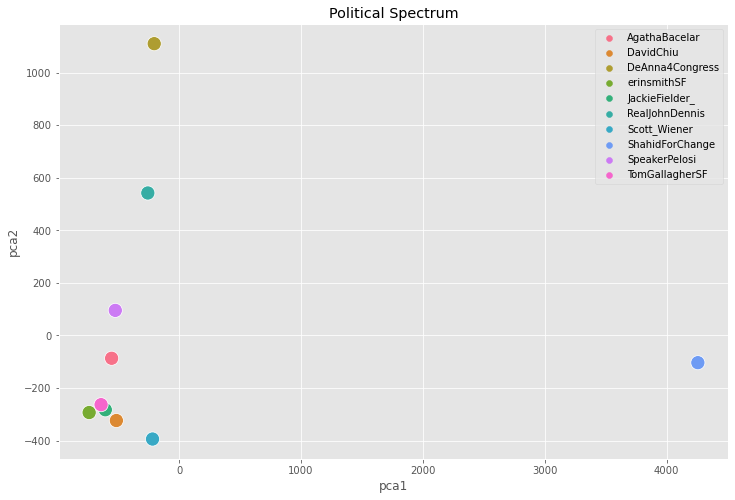

In [47]:
reduced_data = PCA(n_components=2).fit_transform(big_df)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

plt.figure(figsize=(12,8))
sns.scatterplot(x="pca1", y="pca2", s=200,hue=big_df.index, data=results)
plt.title('Political Spectrum')
plt.show()

In [48]:
results.set_index(big_df.index)
#results.set_index(tryit.index).to_pickle('2D_PCA_table.pkl')

,pca1,pca2
AgathaBacelar,-553.866226,-86.766922
DavidChiu,-515.040358,-323.636876
DeAnna4Congress,-204.478505,1109.938968
erinsmithSF,-738.512003,-293.250822
JackieFielder_,-605.872406,-282.707847
RealJohnDennis,-256.838193,541.982804
Scott_Wiener,-218.200105,-394.028206
ShahidForChange,4257.122436,-103.609310
SpeakerPelosi,-523.879692,95.410778
TomGallagherSF,-640.434948,-263.332568


Yes it worked! Generally, it seemed like we are somewhat accurately showing difference in candidates. The far left candidate (Shahid) and far right candidate (DeAnna) are both separated from the pack. John Dennis, the other main republican is also separated from the pack and towards the direction of DeAnna but not as far.

In [49]:
#tryit.to_pickle('politician vecotr.pkl')

### 3D

In [50]:
reduced_data_3d = PCA(n_components=3).fit_transform(big_df)
results_3d = pd.DataFrame(reduced_data_3d,columns=['pca1','pca2', 'pca3'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

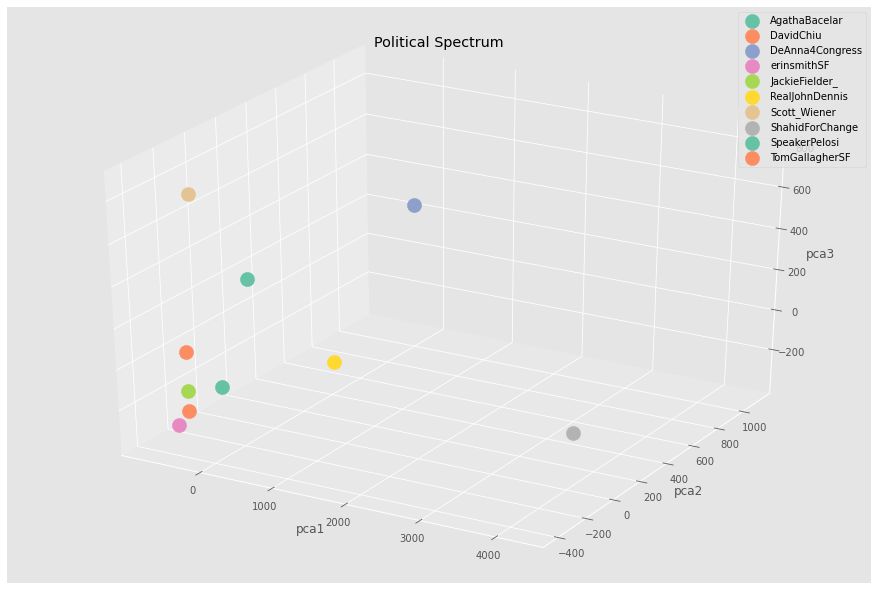

In [51]:
fig = plt.figure(figsize=(12,8))

ax = Axes3D(fig) 

color=sns.color_palette("Set2", n_colors=10)
for i,row in enumerate(results_3d.values):
    x=row[0]
    y=row[1]
    z=row[2]
    ax.scatter(x, y, z, c=color[i], s=200, marker='o', label=big_df.index[i])

ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')
plt.legend()

plt.title('Political Spectrum')
plt.show()

In [52]:
results_3d.set_index(big_df.index)

,pca1,pca2,pca3
AgathaBacelar,-553.866226,-86.766922,-217.929048
DavidChiu,-515.040358,-323.636876,56.802866
DeAnna4Congress,-204.478505,1109.938968,245.343965
erinsmithSF,-738.512003,-293.250822,-336.115003
JackieFielder_,-605.872406,-282.707847,-159.295571
RealJohnDennis,-256.838193,541.982804,-336.777736
Scott_Wiener,-218.200105,-394.028206,851.522929
ShahidForChange,4257.122436,-103.609310,-77.839639
SpeakerPelosi,-523.879692,95.410778,241.881584
TomGallagherSF,-640.434948,-263.332568,-267.594346


# Finding each politician's closest comparison

In [53]:
def create_similarity_matrix(similarity_tool,df_vectors):
    """
    Purpose: Take a dataframe with vectors of politicians and output a matrix showing similarity between them
    Arguments: similarity_tool: cosine similarity or euclidean distance, a dataframe with vectors
    Returns: a brand new dataframe with similarity scores
    """
    
    similarities = []
    
    iters = len(df_vectors.index)
    for i in range(iters):
        first_vec = df_vectors.iloc[i,:].values.reshape(1,-1)
        similarities.append([])
        for j in range(iters):
            second_vec = df_vectors.iloc[j,:].values.reshape(1,-1)
            similarities[i].append(similarity_tool(first_vec,second_vec)[0][0])
    
                
    df = pd.DataFrame(similarities, index=df_vectors.index, columns = df_vectors.index)      
    
    return df

In [54]:
create_similarity_matrix(cosine_similarity,big_df)

,AgathaBacelar,DavidChiu,DeAnna4Congress,erinsmithSF,JackieFielder_,RealJohnDennis,Scott_Wiener,ShahidForChange,SpeakerPelosi,TomGallagherSF
AgathaBacelar,1.000000,0.297243,0.458327,0.087869,0.370249,0.383878,0.337342,0.306213,0.285165,0.323180
DavidChiu,0.297243,1.000000,0.346132,0.030461,0.670634,0.265525,0.782513,0.417985,0.325485,0.515157
DeAnna4Congress,0.458327,0.346132,1.000000,0.078480,0.403004,0.675509,0.367070,0.376605,0.448624,0.444781
erinsmithSF,0.087869,0.030461,0.078480,1.000000,0.049767,0.059706,0.022443,0.034941,0.002686,0.038164
JackieFielder_,0.370249,0.670634,0.403004,0.049767,1.000000,0.320148,0.725012,0.457815,0.318157,0.610273
RealJohnDennis,0.383878,0.265525,0.675509,0.059706,0.320148,1.000000,0.266601,0.435483,0.277637,0.386979
Scott_Wiener,0.337342,0.782513,0.367070,0.022443,0.725012,0.266601,1.000000,0.423028,0.343761,0.535151
ShahidForChange,0.306213,0.417985,0.376605,0.034941,0.457815,0.435483,0.423028,1.000000,0.234103,0.517872
SpeakerPelosi,0.285165,0.325485,0.448624,0.002686,0.318157,0.277637,0.343761,0.234103,1.000000,0.292696
TomGallagherSF,0.323180,0.515157,0.444781,0.038164,0.610273,0.386979,0.535151,0.517872,0.292696,1.000000


In [55]:
cos_sim_df = create_similarity_matrix(cosine_similarity,big_df)
for column in cos_sim_df:
    print('The closest person to ' + str(column) + ' is ' + str(cos_sim_df[column].sort_values(ascending=False).index[1]))

The closest person to AgathaBacelar is DeAnna4Congress
The closest person to DavidChiu is Scott_Wiener
The closest person to DeAnna4Congress is RealJohnDennis
The closest person to erinsmithSF is AgathaBacelar
The closest person to JackieFielder_ is Scott_Wiener
The closest person to RealJohnDennis is DeAnna4Congress
The closest person to Scott_Wiener is DavidChiu
The closest person to ShahidForChange is TomGallagherSF
The closest person to SpeakerPelosi is DeAnna4Congress
The closest person to TomGallagherSF is JackieFielder_


In [56]:
create_similarity_matrix(euclidean_distances,big_df)

,AgathaBacelar,DavidChiu,DeAnna4Congress,erinsmithSF,JackieFielder_,RealJohnDennis,Scott_Wiener,ShahidForChange,SpeakerPelosi,TomGallagherSF
AgathaBacelar,0.000043,774.505331,1454.338424,701.168619,654.617087,1140.604414,1319.025601,4841.232742,1188.013433,664.495600
DavidChiu,774.505331,0.000000,1534.659161,596.936171,450.189101,1197.026719,984.094908,4791.027027,1135.374676,522.362576
DeAnna4Congress,1454.338424,1534.659161,0.000000,1634.927261,1534.705477,1210.310127,1708.710672,4647.745848,1528.068917,1555.821942
erinsmithSF,701.168619,596.936171,1634.927261,0.000000,319.621966,1207.678366,1378.273436,5009.571198,1179.394812,202.814158
JackieFielder_,654.617087,450.189101,1534.705477,319.621966,0.000000,1146.428299,1167.463544,4871.660477,1119.479251,253.528329
RealJohnDennis,1140.604414,1197.026719,1210.310127,1207.678366,1146.428299,0.000000,1572.108865,4613.708274,1435.002996,1144.917068
Scott_Wiener,1319.025601,984.094908,1708.710672,1378.273436,1167.463544,1572.108865,0.000053,4599.524997,1474.205434,1281.316099
ShahidForChange,4841.232742,4791.027027,4647.745848,5009.571198,4871.660477,4613.708274,4599.524997,0.000000,4870.591030,4907.765702
SpeakerPelosi,1188.013433,1135.374676,1528.068917,1179.394812,1119.479251,1435.002996,1474.205434,4870.591030,0.000068,1136.678412
TomGallagherSF,664.495600,522.362576,1555.821942,202.814158,253.528329,1144.917068,1281.316099,4907.765702,1136.678412,0.000008


In [57]:
euc_dis_df = create_similarity_matrix(euclidean_distances,big_df)
for column in euc_dis_df:
    print('The closest person to ' + str(column) + ' is ' + str(euc_dis_df[column].sort_values().index[1]))

The closest person to AgathaBacelar is JackieFielder_
The closest person to DavidChiu is JackieFielder_
The closest person to DeAnna4Congress is RealJohnDennis
The closest person to erinsmithSF is TomGallagherSF
The closest person to JackieFielder_ is TomGallagherSF
The closest person to RealJohnDennis is AgathaBacelar
The closest person to Scott_Wiener is DavidChiu
The closest person to ShahidForChange is Scott_Wiener
The closest person to SpeakerPelosi is JackieFielder_
The closest person to TomGallagherSF is erinsmithSF


In [58]:
#heyo.to_pickle('cosine_similarity_matrix.pkl')
#ok.to_pickle('euclidean_distances_matrix.pkl')

In [59]:
def recommend(twitter_handle,similarity_tool):
    df,num_tweets = get_politician_vectors(twitter_handle)#,neu=True,neg=True,pos=True,compound=True)
    new_df = pd.concat([big_df, df], axis=0)
    new_df = new_df.fillna(0)
    sim_df = create_similarity_matrix(similarity_tool,new_df)
    if similarity_tool == cosine_similarity:
        return sim_df[twitter_handle].sort_values(ascending=False)
    if similarity_tool == euclidean_distances:
        return sim_df[twitter_handle].sort_values()

In [60]:
recommend('realDonaldTrump',cosine_similarity)

realDonaldTrump    1.000000
DeAnna4Congress    0.611555
SpeakerPelosi      0.461784
RealJohnDennis     0.432577
AgathaBacelar      0.383902
Scott_Wiener       0.381864
JackieFielder_     0.381373
TomGallagherSF     0.364483
DavidChiu          0.346580
ShahidForChange    0.249508
erinsmithSF        0.057238
Name: realDonaldTrump, dtype: float64

In [61]:
recommend('BernieSanders',cosine_similarity)

BernieSanders      1.000000
SpeakerPelosi      0.576437
DeAnna4Congress    0.525629
TomGallagherSF     0.425823
JackieFielder_     0.405676
AgathaBacelar      0.398783
Scott_Wiener       0.396458
DavidChiu          0.373050
RealJohnDennis     0.317874
ShahidForChange    0.273314
erinsmithSF        0.052787
Name: BernieSanders, dtype: float64

In [62]:
recommend('JoeBiden',cosine_similarity)

JoeBiden           1.000000
AgathaBacelar      0.621973
SpeakerPelosi      0.530438
DeAnna4Congress    0.460406
Scott_Wiener       0.308727
JackieFielder_     0.301679
TomGallagherSF     0.288526
DavidChiu          0.282274
RealJohnDennis     0.274054
ShahidForChange    0.199892
erinsmithSF        0.041899
Name: JoeBiden, dtype: float64

In [63]:
recommend('AOC',cosine_similarity)

AOC                1.000000
DeAnna4Congress    0.608562
SpeakerPelosi      0.503837
AgathaBacelar      0.501721
JackieFielder_     0.493904
Scott_Wiener       0.464325
TomGallagherSF     0.411119
RealJohnDennis     0.388130
DavidChiu          0.384360
ShahidForChange    0.293416
erinsmithSF        0.088903
Name: AOC, dtype: float64

Looks like we have a good proof of concept. The next step is to continue tweaking the recommendation engine